In [2]:
import pandas as pd
import os

# data stored
data_path = '/Users/smallina/Desktop/Stanford/Data'
train_data_path = os.path.join(data_path, 'cars_train/')
test_data_path = os.path.join(data_path, 'cars_test/')
train_labels_path = os.path.join(data_path, 'anno_train.csv')
test_labels_path = os.path.join(data_path, 'anno_test.csv')

# annotate columns
anno_columns = ['image', 'x1', 'y1', 'x2', 'y2', 'car_model']

# load data into csv file
train_df = pd.read_csv(train_labels_path, header=None, names=anno_columns)
test_df = pd.read_csv(test_labels_path, header=None, names=anno_columns)

# print 
print(train_df.head())
print(test_df.head())

/Users/smallina/opt/anaconda3/envs/cse185/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


       image   x1   y1    x2    y2  car_model
0  00001.jpg   39  116   569   375         14
1  00002.jpg   36  116   868   587          3
2  00003.jpg   85  109   601   381         91
3  00004.jpg  621  393  1484  1096        134
4  00005.jpg   14   36   133    99        106
       image   x1   y1   x2   y2  car_model
0  00001.jpg   30   52  246  147        181
1  00002.jpg  100   19  576  203        103
2  00003.jpg   51  105  968  659        145
3  00004.jpg   67   84  581  407        187
4  00005.jpg  140  151  593  339        185


In [3]:
def load_image(img_path, target_size=(224, 224)):
    """Loads and preprocesses an image."""
    img = cv2.imread(img_path)
    img = cv2.resize(img, target_size)
    img = img.astype('float32') / 255.0
    return img

def preprocess_data(df, img_dir):
    """Processes the dataframe and returns image paths with labels."""
    data_list = []
    for index, row in df.iterrows():
        img_path = os.path.join(img_dir, row['image'])  
        label = row['car_model']
        data_list.append((label, img_path))
    return data_list

train_data = preprocess_data(train_df, train_data_path)
test_data = preprocess_data(test_df, test_data_path)

print("Loaded train data:", len(train_data))
print("Loaded test data:", len(test_data))

Loaded train data: 8144
Loaded test data: 8041


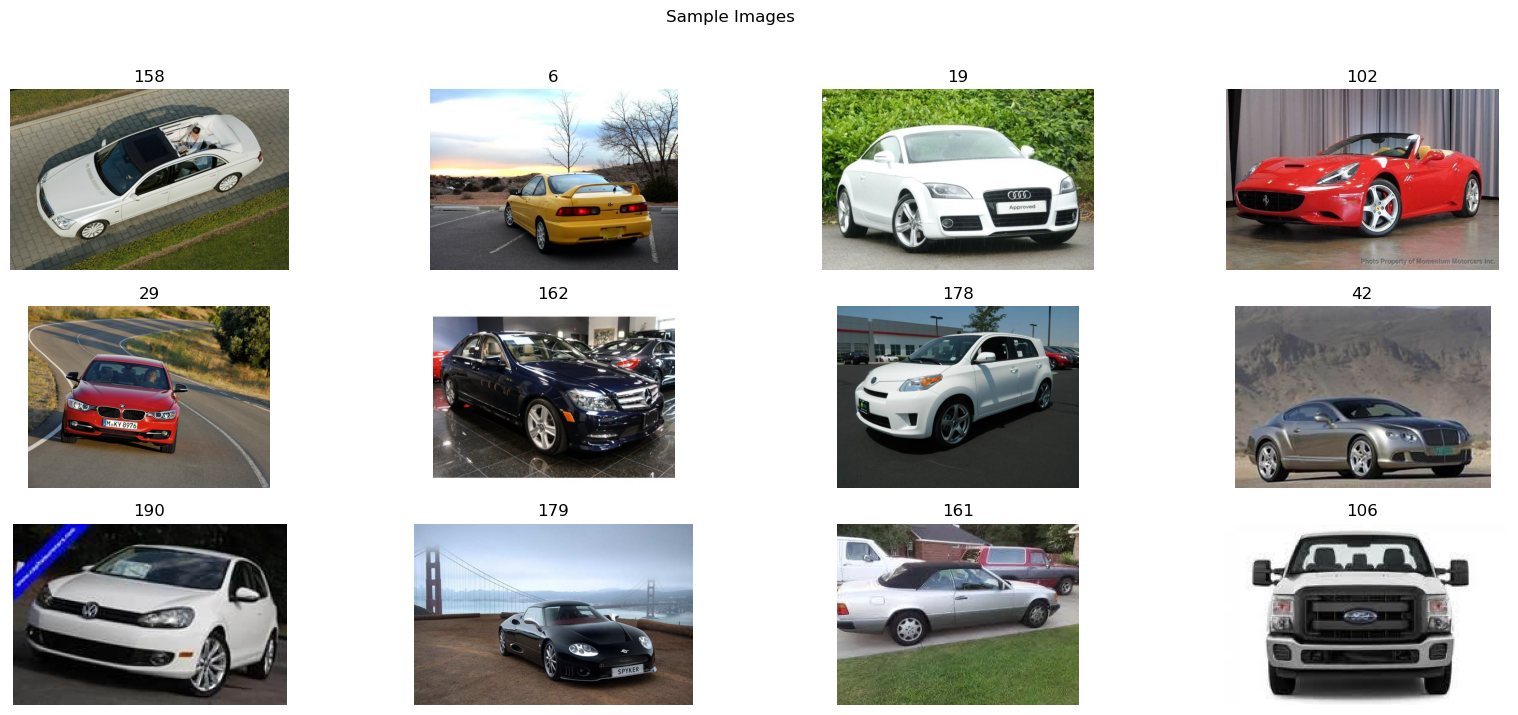

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

image_samples = np.random.randint(0,high=len(train_data)-1, size=12)

fig = plt.figure(figsize=(20,8))
for i,img_idx in enumerate(image_samples):
    axs = fig.add_subplot(3,4,i+1)
    axs.set_title(train_data[img_idx][0])
    # Read image
    image = cv2.imread(train_data[img_idx][1])
    # convert to rgb
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.axis('off')

plt.suptitle("Sample Images")
plt.show()

In [4]:
def compute_dataset_metrics(data_list):
  data_list_with_metrics = []
  for item in data_list:
    # Read image
    image = cv2.imread(item[1])
    data_list_with_metrics.append((item[0],item[1],image.shape[0],image.shape[1],image.nbytes / (1024 * 1024.0)))

  # Build a dataframe
  data_list_with_metrics = np.asarray(data_list_with_metrics)
  dataset_df = pd.DataFrame({
    'label': data_list_with_metrics[:, 0],
    'path': data_list_with_metrics[:, 1],
    'height': data_list_with_metrics[:, 2],
    'width': data_list_with_metrics[:, 3],
    'size': data_list_with_metrics[:, 4],
    })

  dataset_df["height"] = dataset_df["height"].astype(int)
  dataset_df["width"] = dataset_df["width"].astype(int)
  dataset_df["size"] = dataset_df["size"].astype(float)

  dataset_mem_size = dataset_df["size"].sum()
  value_counts = dataset_df["label"].value_counts()
  height_details = dataset_df["height"].describe()
  width_details = dataset_df["width"].describe()

  print("Dataset Metrics:")
  print("----------------")
  print("Label Counts:")
  print(value_counts)
  print("Image Width:")
  print("Min:",width_details["min"]," Max:",width_details["max"])
  print("Image Height:")
  print("Min:",height_details["min"]," Max:",height_details["max"])
  print("Size in memory:",round(dataset_df["size"].sum(),2),"MB")

In [7]:
compute_dataset_metrics(train_data)

Dataset Metrics:
----------------
Label Counts:
label
119    68
79     49
161    48
167    48
144    47
       ..
175    31
64     30
158    29
99     28
136    24
Name: count, Length: 196, dtype: int64
Image Width:
Min: 78.0  Max: 5616.0
Image Height:
Min: 57.0  Max: 3744.0
Size in memory: 11114.81 MB


In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np

train_x = [os.path.join(train_data_path, img) for img in train_df['image'].values]
train_y = train_df['car_model'].values 

test_x = [os.path.join(test_data_path, img) for img in test_df['image'].values]
test_y = test_df['car_model'].values  


split_idx = int(len(train_x) * 0.8)
validate_x = train_x[split_idx:]
validate_y = train_y[split_idx:]
train_x = train_x[:split_idx]
train_y = train_y[:split_idx]


label2index = {label: idx for idx, label in enumerate(sorted(set(train_y)))}
index2label = {idx: label for label, idx in label2index.items()}


num_classes = len(label2index)

class CarDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = [label2index[label] for label in labels]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


image_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


train_dataset = CarDataset(train_x, train_y, transform=image_transforms['train'])
val_dataset = CarDataset(validate_x, validate_y, transform=image_transforms['val'])
test_dataset = CarDataset(test_x, test_y, transform=image_transforms['test'])


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)


for images, labels in train_loader:
    print(images.shape, labels.shape)
    break

torch.Size([32, 3, 224, 224]) torch.Size([32])


In [5]:
import json
import time

class JsonEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(JsonEncoder, self).default(obj)

experiment_name = None

def create_experiment():
    global experiment_name
    experiment_name = "experiment_" + str(int(time.time()))

    # Create experiment folder
    if not os.path.exists(experiment_name):
        os.mkdir(experiment_name)

def save_model(model, model_name="model01"):
    # Save the entire model (structure + weights)
    torch.save(model.state_dict(), os.path.join(experiment_name, model_name + ".pth"))

def get_model_size(model_name="model01"):
    model_size = os.stat(os.path.join(experiment_name, model_name + ".pth")).st_size
    return model_size

def evaluate_save_model(model, test_loader, model_train_history, execution_time, learning_rate, batch_size, epochs, optimizer, save=True, device="cpu"):

    num_epochs = len(model_train_history["loss"])
    fig = plt.figure(figsize=(15, 5))


    axs = fig.add_subplot(1, 2, 1)
    axs.set_title('Loss')
    for metric in ["loss", "val_loss"]:
        axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
    axs.legend()


    axs = fig.add_subplot(1, 2, 2)
    axs.set_title('Accuracy')
    for metric in ["accuracy", "val_accuracy"]:
        axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
    axs.legend()

    plt.show()


    model.eval()
    correct = 0
    total = 0
    criterion = nn.CrossEntropyLoss() 

    test_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    avg_test_loss = test_loss / len(test_loader)

    evaluation_results = {"loss": avg_test_loss, "accuracy": accuracy}
    print(evaluation_results)

    if save:
        # Save model
        save_model(model, model_name=model.__class__.__name__)
        model_size = get_model_size(model_name=model.__class__.__name__)

        # Save model history
        with open(os.path.join(experiment_name, model.__class__.__name__ + "_train_history.json"), "w") as json_file:
            json.dump(model_train_history, json_file, cls=JsonEncoder)

        trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
        non_trainable_parameters = sum(p.numel() for p in model.parameters() if not p.requires_grad)

        # Save model metrics
        metrics = {
            "trainable_parameters": trainable_parameters,
            "execution_time": execution_time,
            "loss": evaluation_results["loss"],
            "accuracy": evaluation_results["accuracy"],
            "model_size": model_size,
            "learning_rate": learning_rate,
            "batch_size": batch_size,
            "epochs": epochs,
            "optimizer": type(optimizer).__name__
        }
        with open(os.path.join(experiment_name, model.__class__.__name__ + "_model_metrics.json"), "w") as json_file:
            json.dump(metrics, json_file, cls=JsonEncoder)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader

num_classes = len(label2index)


model = models.resnet18(pretrained=True)  


model.fc = nn.Linear(512, num_classes)


for param in model.parameters():
    param.requires_grad = False


for param in model.fc.parameters():
    param.requires_grad = True

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)


optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)  
criterion = nn.CrossEntropyLoss()


def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()  
            outputs = model(inputs)  
            loss = criterion(outputs, targets)  
            loss.backward()  
            optimizer.step()  

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if batch_idx % 10 == 0:  
                print(f'Epoch [{epoch + 1}/{epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')

        train_acc = 100. * correct / total
        print(f'Train Accuracy: {train_acc:.2f}%')

        
        validate_model(model, val_loader, criterion)


def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_acc = 100. * correct / total
    val_loss /= len(val_loader)
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')

train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5)

/Users/smallina/opt/anaconda3/envs/cse185/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/smallina/opt/anaconda3/envs/cse185/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Epoch [1/5], Batch [0/204], Loss: 5.5674
Epoch [1/5], Batch [10/204], Loss: 5.5841
Epoch [1/5], Batch [20/204], Loss: 5.3654
Epoch [1/5], Batch [30/204], Loss: 5.4726
Epoch [1/5], Batch [40/204], Loss: 5.3321
Epoch [1/5], Batch [50/204], Loss: 5.3484
Epoch [1/5], Batch [60/204], Loss: 5.4170
Epoch [1/5], Batch [70/204], Loss: 5.3640
Epoch [1/5], Batch [80/204], Loss: 5.2866
Epoch [1/5], Batch [90/204], Loss: 5.4163
Epoch [1/5], Batch [100/204], Loss: 5.3482
Epoch [1/5], Batch [110/204], Loss: 5.3201
Epoch [1/5], Batch [120/204], Loss: 5.3917
Epoch [1/5], Batch [130/204], Loss: 5.1918
Epoch [1/5], Batch [140/204], Loss: 5.3357
Epoch [1/5], Batch [150/204], Loss: 5.2922
Epoch [1/5], Batch [160/204], Loss: 5.3137
Epoch [1/5], Batch [170/204], 

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from torch.utils.data import DataLoader

num_classes = len(label2index)

def load_pretrained_model(model_name, num_classes):
    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(4096, num_classes)
    elif model_name == 'mobilenet_v2':
        model = models.mobilenet_v2(pretrained=True)
        model.classifier[1] = nn.Linear(1280, num_classes)
    else:
        raise ValueError("Unsupported model. Choose between 'vgg16' and 'mobilenet_v2'.")
    
    return model

model_name = 'vgg16'  
model = load_pretrained_model(model_name, num_classes)


for param in model.parameters():
    param.requires_grad = False

if model_name == 'vgg16':
    for param in model.classifier[6].parameters():
        param.requires_grad = True
elif model_name == 'mobilenet_v2':
    for param in model.classifier[1].parameters():
        param.requires_grad = True


device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)


optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()


def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad() 
            outputs = model(inputs)  
            loss = criterion(outputs, targets)  
            loss.backward()  
            optimizer.step()  

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if batch_idx % 10 == 0:  
                print(f'Epoch [{epoch + 1}/{epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')

        train_acc = 100. * correct / total
        print(f'Train Accuracy: {train_acc:.2f}%')

      
        validate_model(model, val_loader, criterion)

def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_acc = 100. * correct / total
    val_loss /= len(val_loader)
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')

train_model(model, train_loader, val_loader, criterion, optimizer, epochs=3)

/Users/smallina/opt/anaconda3/envs/cse185/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/3], Batch [0/204], Loss: 5.4797
Epoch [1/3], Batch [10/204], Loss: 5.4128
Epoch [1/3], Batch [20/204], Loss: 5.2191
Epoch [1/3], Batch [30/204], Loss: 5.2085
Epoch [1/3], Batch [40/204], Loss: 5.2931
Epoch [1/3], Batch [50/204], Loss: 5.2515
Epoch [1/3], Batch [60/204], Loss: 4.9363
Epoch [1/3], Batch [70/204], Loss: 5.2780
Epoch [1/3], Batch [80/204], Loss: 5.2145
Epoch [1/3], Batch [90/204], Loss: 5.1433
Epoch [1/3], Batch [100/204], Loss: 4.9232
Epoch [1/3], Batch [110/204], Loss: 4.9091
Epoch [1/3], Batch [120/204], Loss: 4.7991
Epoch [1/3], Batch [130/204], Loss: 4.9518
Epoch [1/3], Batch [140/204], Loss: 4.6324
Epoch [1/3], Batch [150/204], Loss: 4.7441
Epoch [1/3], Batch [160/204], Loss: 4.6348
Epoch [1/3], Batch [170/204], Loss: 4.4770
Epoch [1/3], Batch [180/204], Loss: 4.5900
Epoch [1/3], Batch [190/204], Loss: 4.9039
Epoch [1/3], Batch [200/204], Loss: 4.5213
Train Accuracy: 3.48%
Validation Loss: 4.4822, Validation Accuracy: 9.94%
Epoch [2/3], Batch [0/204], Loss: 

In [8]:
model_name = 'mobilenet_v2' 
model = load_pretrained_model(model_name, num_classes)


for param in model.parameters():
    param.requires_grad = False


if model_name == 'vgg16':
    for param in model.classifier[6].parameters():
        param.requires_grad = True
elif model_name == 'mobilenet_v2':
    for param in model.classifier[1].parameters():
        param.requires_grad = True


device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)


optimizer = optim.SGD(model.classifier.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()



def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()  
            outputs = model(inputs)  
            loss = criterion(outputs, targets)  
            loss.backward()  
            optimizer.step()  

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if batch_idx % 10 == 0:  
                print(f'Epoch [{epoch + 1}/{epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')

        train_acc = 100. * correct / total
        print(f'Train Accuracy: {train_acc:.2f}%')

        validate_model(model, val_loader, criterion)

def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_acc = 100. * correct / total
    val_loss /= len(val_loader)
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')

train_model(model, train_loader, val_loader, criterion, optimizer, epochs=3)

/Users/smallina/opt/anaconda3/envs/cse185/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/3], Batch [0/204], Loss: 5.3991
Epoch [1/3], Batch [10/204], Loss: 5.3878
Epoch [1/3], Batch [20/204], Loss: 5.4331
Epoch [1/3], Batch [30/204], Loss: 5.4425
Epoch [1/3], Batch [40/204], Loss: 5.4029
Epoch [1/3], Batch [50/204], Loss: 5.3498
Epoch [1/3], Batch [60/204], Loss: 5.3526
Epoch [1/3], Batch [70/204], Loss: 5.2978
Epoch [1/3], Batch [80/204], Loss: 5.3486
Epoch [1/3], Batch [90/204], Loss: 5.3205
Epoch [1/3], Batch [100/204], Loss: 5.3712
Epoch [1/3], Batch [110/204], Loss: 5.2573
Epoch [1/3], Batch [120/204], Loss: 5.1670
Epoch [1/3], Batch [130/204], Loss: 5.1576
Epoch [1/3], Batch [140/204], Loss: 5.0833
Epoch [1/3], Batch [150/204], Loss: 5.1300
Epoch [1/3], Batch [160/204], Loss: 5.1898
Epoch [1/3], Batch [170/204], Loss: 5.1628
Epoch [1/3], Batch [180/204], Loss: 4.9908
Epoch [1/3], Batch [190/204], Loss: 5.0704
Epoch [1/3], Batch [200/204], Loss: 5.1700
Train Accuracy: 1.44%
Validation Loss: 5.1171, Validation Accuracy: 4.11%
Epoch [2/3], Batch [0/204], Loss: 

In [13]:
# Set up hyperparameters
model_name = "vgg16_finetune"
learning_rate = 0.0001  
batch_size = 32
epochs = 1 


device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


for param in model.parameters():
    param.requires_grad = True  

optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate, momentum=0.9)
criterion = nn.CrossEntropyLoss()  

def fine_tune_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    model.to(device)
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()  
            outputs = model(inputs) 
            loss = criterion(outputs, targets) 
            loss.backward()  
            optimizer.step()  

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if batch_idx % 10 == 0:  
                print(f'Epoch [{epoch + 1}/{epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')

        train_acc = 100. * correct / total
        print(f'Train Accuracy: {train_acc:.2f}%')


        validate_model(model, val_loader, criterion)


def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_acc = 100. * correct / total
    val_loss /= len(val_loader)
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%')

# Step 4: Fine-tune the model for a few more epochs
fine_tune_model(model, train_loader, val_loader, criterion, optimizer, epochs=1)

# Step 5: Save the model and evaluate it on the test set
def save_model(model, model_name="vgg16_finetune.pth"):
    torch.save(model.state_dict(), model_name)

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    accuracy = 100. * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')

# Save and evaluate the model
save_model(model, model_name="vgg16_finetune.pth")
evaluate_model(model, test_loader)

Epoch [1/1], Batch [0/204], Loss: 4.6926
Epoch [1/1], Batch [10/204], Loss: 4.3730
Epoch [1/1], Batch [20/204], Loss: 4.6193
Epoch [1/1], Batch [30/204], Loss: 4.5139
Epoch [1/1], Batch [40/204], Loss: 4.5583
Epoch [1/1], Batch [50/204], Loss: 4.5466
Epoch [1/1], Batch [60/204], Loss: 4.6018
Epoch [1/1], Batch [70/204], Loss: 4.4662
Epoch [1/1], Batch [80/204], Loss: 4.4598
Epoch [1/1], Batch [90/204], Loss: 4.4982
Epoch [1/1], Batch [100/204], Loss: 4.5843
Epoch [1/1], Batch [110/204], Loss: 4.6606
Epoch [1/1], Batch [120/204], Loss: 4.5519
Epoch [1/1], Batch [130/204], Loss: 4.3852
Epoch [1/1], Batch [140/204], Loss: 4.4147
Epoch [1/1], Batch [150/204], Loss: 4.3280
Epoch [1/1], Batch [160/204], Loss: 4.4337
Epoch [1/1], Batch [170/204], Loss: 4.3005
Epoch [1/1], Batch [180/204], Loss: 4.5248
Epoch [1/1], Batch [190/204], Loss: 4.4878
Epoch [1/1], Batch [200/204], Loss: 4.4047
Train Accuracy: 16.72%
Validation Loss: 4.5759, Validation Accuracy: 12.28%
Test Accuracy: 14.26%
